# **Step 1: Import necessary libraries**

In [1]:
# Import neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.option_context('mode.use_inf_as_na', True)

# **Step 2: Explore, clean and feature engineering**

In [ ]:
#Import data:
path = "./data/churn_prediction.xlsx"
df = pd.read_excel(path, sheet_name="Sheet1")

## Explore shape and data info

In [3]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [4]:
# Check first 5 rows of the dataset
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


## Data Balance

In [5]:

distribute = df.groupby('Churn', as_index=False)['Churn'].count()
distribute['%'] = distribute['Churn'] / len(df) * 100
distribute

,Churn,%
0,4682,83.161634
1,948,16.838366


- Tỉ lệ được phân bổ tốt, không cần thực hiện resample

## Data duplicates

In [6]:
# Data duplicates
df.duplicated().sum()

0

## Null values

In [7]:
missing_contribute = df.isna().sum().sort_values(ascending=False).reset_index(name='nan_count')

missing_contribute['%'] = missing_contribute['nan_count'] / len(df) * 100

missing_contribute[missing_contribute['nan_count'] > 0]

missing_contribute['data_type'] = missing_contribute['index'].apply(lambda x: df[x].dtype)

missing_contribute = missing_contribute[missing_contribute['nan_count'] > 0]

missing_contribute

,index,nan_count,%,data_type
0,DaySinceLastOrder,307,5.452931,float64
1,OrderAmountHikeFromlastYear,265,4.706927,float64
2,Tenure,264,4.689165,float64
3,OrderCount,258,4.582593,float64
4,CouponUsed,256,4.547069,float64
5,HourSpendOnApp,255,4.529307,float64
6,WarehouseToHome,251,4.458259,float64


In [8]:
# Test xem nếu dropna sẽ mất bao nhiêu dữ liệu
test_df = df.copy()

test_df.dropna(inplace=True)

print(f"Original dataset have {len(df)} rows\n", f"Original dataset have {len(test_df)} rows\n", f"Decrease: {100.0 * (len(df)-len(test_df)) / len(df):.2f}% compared to original data")

Original dataset have 5630 rows
 Original dataset have 3774 rows
 Decrease: 32.97% compared to original data


>* Có quá nhiều giá trị null, dropna sẽ khiến mất quá nhiều thông tin và có thể làm ảnh hưởng đến model. 
>* --> Thực hiện SimpleImputer.

### Summary about dataset after EDA:

- This dataset comes from a telecom company aiming to predict which customers might leave (“churn”) and why.  
- Dataset contains information on:  
  - Basic profiles (CustomerID, Gender, MaritalStatus, CityTier).  
  - Service usage (Tenure in months, HourSpendOnApp, NumberOfDeviceRegistered).  
  - Engagement metrics (OrderCount, CouponUsed, CashbackAmount).  
  - Business signals like SatisfactionScore (1–5), Complain count, and OrderAmountHikeFromlastYear help gauge loyalty and spending trends.  
- For example, a customer with high Tenure but low HourSpendOnApp and frequent Complaints may be at risk, while someone who’s used many coupons and has a short DaySinceLastOrder often stays engaged.  
- **Null‐value analysis:** simply dropping missing rows would shrink the data from 5,630 to 3,774 records (−32.97%), so we’ll use statistical imputation (e.g. SimpleImputer) instead of `dropna()` to preserve our sample size.  
- With just 20 columns, it’s compact enough to explore quickly yet rich enough to build a solid churn‐prediction model.

---

## Impute, Encode, and Scaler

In [40]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


### Separate String and Numeric columns

In [10]:
new_df = df.copy()

In [11]:
cat_cols = []
num_cols = []

for col in new_df.columns:
    if new_df[col].dtype == 'object':
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [12]:
print(f'List of categorical variables \n {cat_cols} \n\n')
print(f'List of numerical variables \n {num_cols}')

List of categorical variables 
 ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus'] 


List of numerical variables 
 ['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


### Thực hiện fillna bằng SimpleImputer với giá trị median

In [13]:
from sklearn.impute import SimpleImputer
# Impute missing values
imputer = SimpleImputer(strategy='median')

new_df[num_cols] = imputer.fit_transform(new_df[num_cols])

new_df.isna().sum()

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

### Encode categorical data

In [14]:
dummies_df = pd.get_dummies(new_df, dtype='int64')
dummies_df

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,50001.0,1.0,4.0,3.0,6.0,3.0,3.0,2.0,9.0,1.0,...,0,0,0,1,0,0,0,0,0,1
1,50002.0,1.0,9.0,1.0,8.0,3.0,4.0,3.0,7.0,1.0,...,1,0,0,0,1,0,0,0,0,1
2,50003.0,1.0,9.0,1.0,30.0,2.0,4.0,3.0,6.0,1.0,...,1,0,0,0,1,0,0,0,0,1
3,50004.0,1.0,0.0,3.0,15.0,2.0,4.0,5.0,8.0,0.0,...,1,0,0,1,0,0,0,0,0,1
4,50005.0,1.0,0.0,1.0,12.0,3.0,3.0,5.0,3.0,0.0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626.0,0.0,10.0,1.0,30.0,3.0,2.0,1.0,6.0,0.0,...,1,0,0,1,0,0,0,0,1,0
5626,55627.0,0.0,13.0,1.0,13.0,3.0,5.0,5.0,6.0,0.0,...,1,1,0,0,0,0,0,0,1,0
5627,55628.0,0.0,1.0,1.0,11.0,3.0,2.0,4.0,3.0,1.0,...,1,0,0,1,0,0,0,0,1,0
5628,55629.0,0.0,23.0,3.0,9.0,4.0,5.0,4.0,4.0,0.0,...,1,0,0,1,0,0,0,0,1,0


### Separate Independent and Dependent Features

In [15]:
X = dummies_df.drop('Churn', axis=1)
y = dummies_df.Churn

print(X.shape, y.shape)

(5630, 35) (5630,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Scale Numeric Data to same scale

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Step 3: EDA and Feature Selection**

In [18]:
clf = DecisionTreeClassifier(max_depth=16, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

### Feature Selection by DecisionTree

In [19]:
# Get feature importances
importances = clf.feature_importances_
 
# Select features with importance greater than a threshold
threshold = 0.06  # Adjust as needed
selected_features = X.columns[importances > threshold]
 
# Use only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected.head()

,Tenure,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
1559,0.0,6.0,1.0,4.0,126.57
993,9.0,2.0,0.0,0.0,120.61
1187,0.0,1.0,0.0,0.0,129.56
188,6.0,7.0,0.0,3.0,218.78
4630,1.0,2.0,0.0,2.0,149.00


In [20]:
important_features = list(X_train_selected.columns) + ['Churn']

eda_df = new_df[important_features].copy()

eda_df

,Tenure,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,4.0,9.0,1.0,5.0,159.93,1.0
1,9.0,7.0,1.0,0.0,120.90,1.0
2,9.0,6.0,1.0,3.0,120.28,1.0
3,0.0,8.0,0.0,3.0,134.07,1.0
4,0.0,3.0,0.0,3.0,129.60,1.0
...,...,...,...,...,...,...
5625,10.0,6.0,0.0,4.0,150.71,0.0
5626,13.0,6.0,0.0,3.0,224.91,0.0
5627,1.0,3.0,1.0,4.0,186.42,0.0
5628,23.0,4.0,0.0,9.0,178.90,0.0


In [21]:
eda_df.groupby('Churn').agg({'Tenure': 'mean', 'DaySinceLastOrder': 'mean', 'CashbackAmount':'mean'})

,Tenure,DaySinceLastOrder,CashbackAmount
Churn,,,
0.0,11.404528,4.709739,180.635203
1.0,3.859705,3.222574,160.370928


### Correlation:

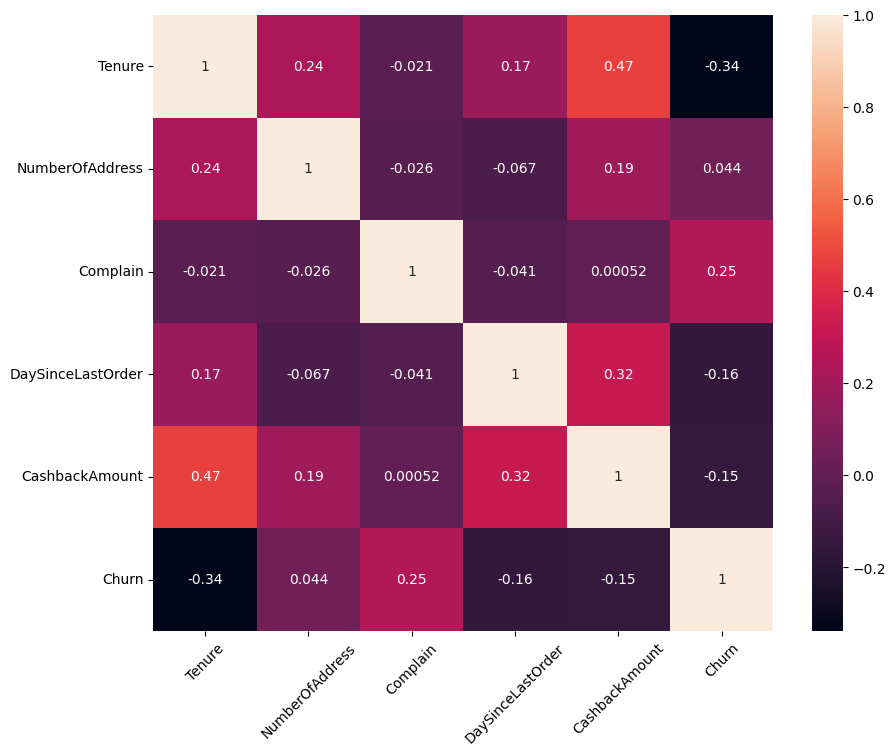

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = sns.heatmap(eda_df.corr(), annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

- Correlation cho thấy những khách hàng có thời gian gắn bó càng dài, Recency cao và CashBackAmout lớn sẽ có tỉ lệ rời bỏ thấp hơn

C:\Users\Alvin Nguyen\AppData\Local\Temp\ipykernel_102384\747584901.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


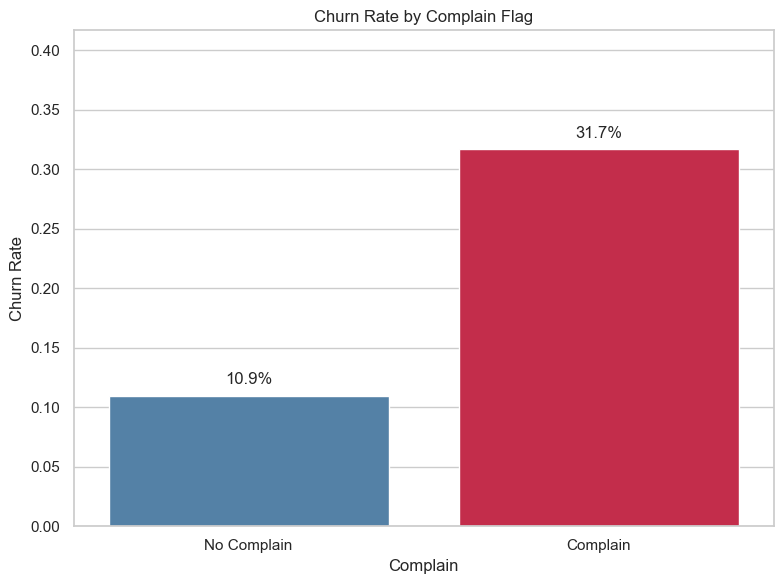

In [23]:
# Tính churn rate theo Complain


churn_rate = (
    eda_df
    .groupby('Complain')['Churn']
    .mean()                      # trung bình Churn (0/1) = tỉ lệ churn
    .reset_index(name='churn_rate')
)

# Map label cho dễ đọc
churn_rate['Complain'] = churn_rate['Complain'].map({0: 'No Complain', 1: 'Complain'})

# Vẽ barplot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.barplot(
    x='Complain', 
    y='churn_rate', 
    data=churn_rate,
    palette=['steelblue','crimson']
)

# Thêm annotation tỉ lệ %
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2, 
        y=height + 0.01, 
        s=f"{height:.1%}", 
        ha='center'
    )

ax.set_title('Churn Rate by Complain Flag')
ax.set_ylabel('Churn Rate')
ax.set_ylim(0, churn_rate['churn_rate'].max() + 0.1)
plt.tight_layout()
plt.show()

### Churn by tenure each bar is 6 months

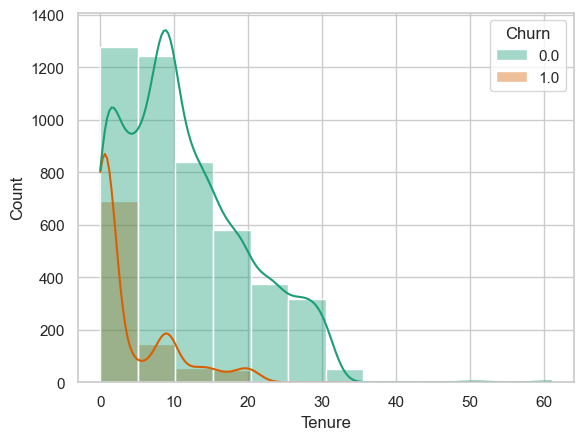

In [24]:
import seaborn as sns

sns.histplot(data=eda_df, x='Tenure', hue='Churn', bins=12, kde=True, palette='Dark2', alpha=0.4)

plt.show()

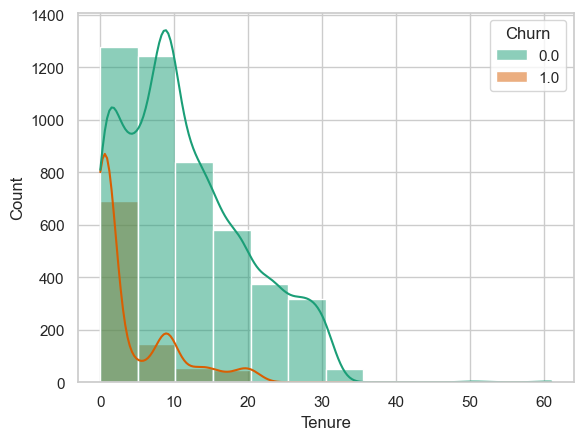

In [25]:
import seaborn as sns

sns.histplot(data=eda_df, x='Tenure', hue='Churn', bins=12, kde=True, palette='Dark2')

plt.show()

### Churn by Day since last order each bar about 3 days

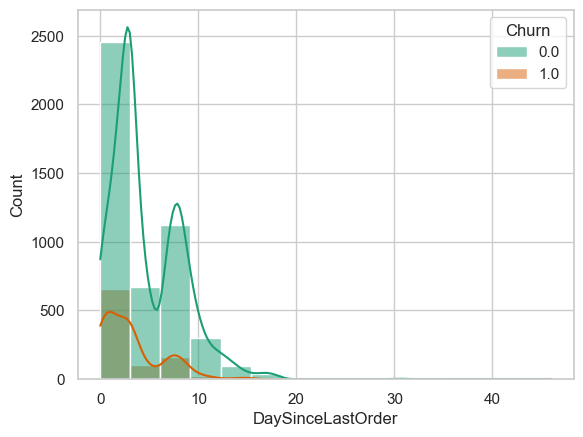

In [26]:
sns.histplot(data=eda_df, x='DaySinceLastOrder', hue='Churn', bins=15, kde=True, palette='Dark2')

plt.show()

### Churn by Cashback Amount each bar about 10$

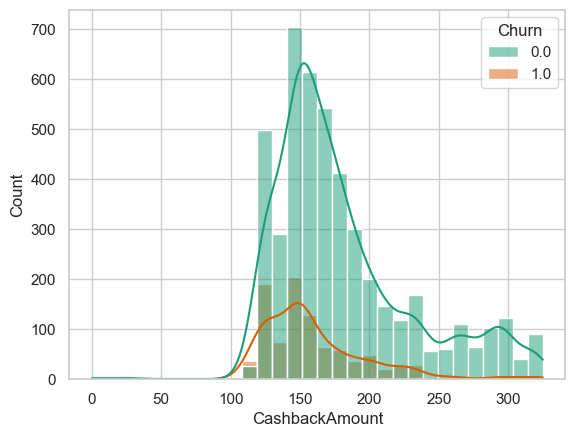

In [27]:
sns.histplot(data=eda_df, x='CashbackAmount', hue='Churn', bins=30, kde=True, palette='Dark2')

plt.show()

### Churn rate by Tenure

## Relationship between variables:

In [28]:
# eda_df['Tenure'] = eda_df['Tenure'].round(2)

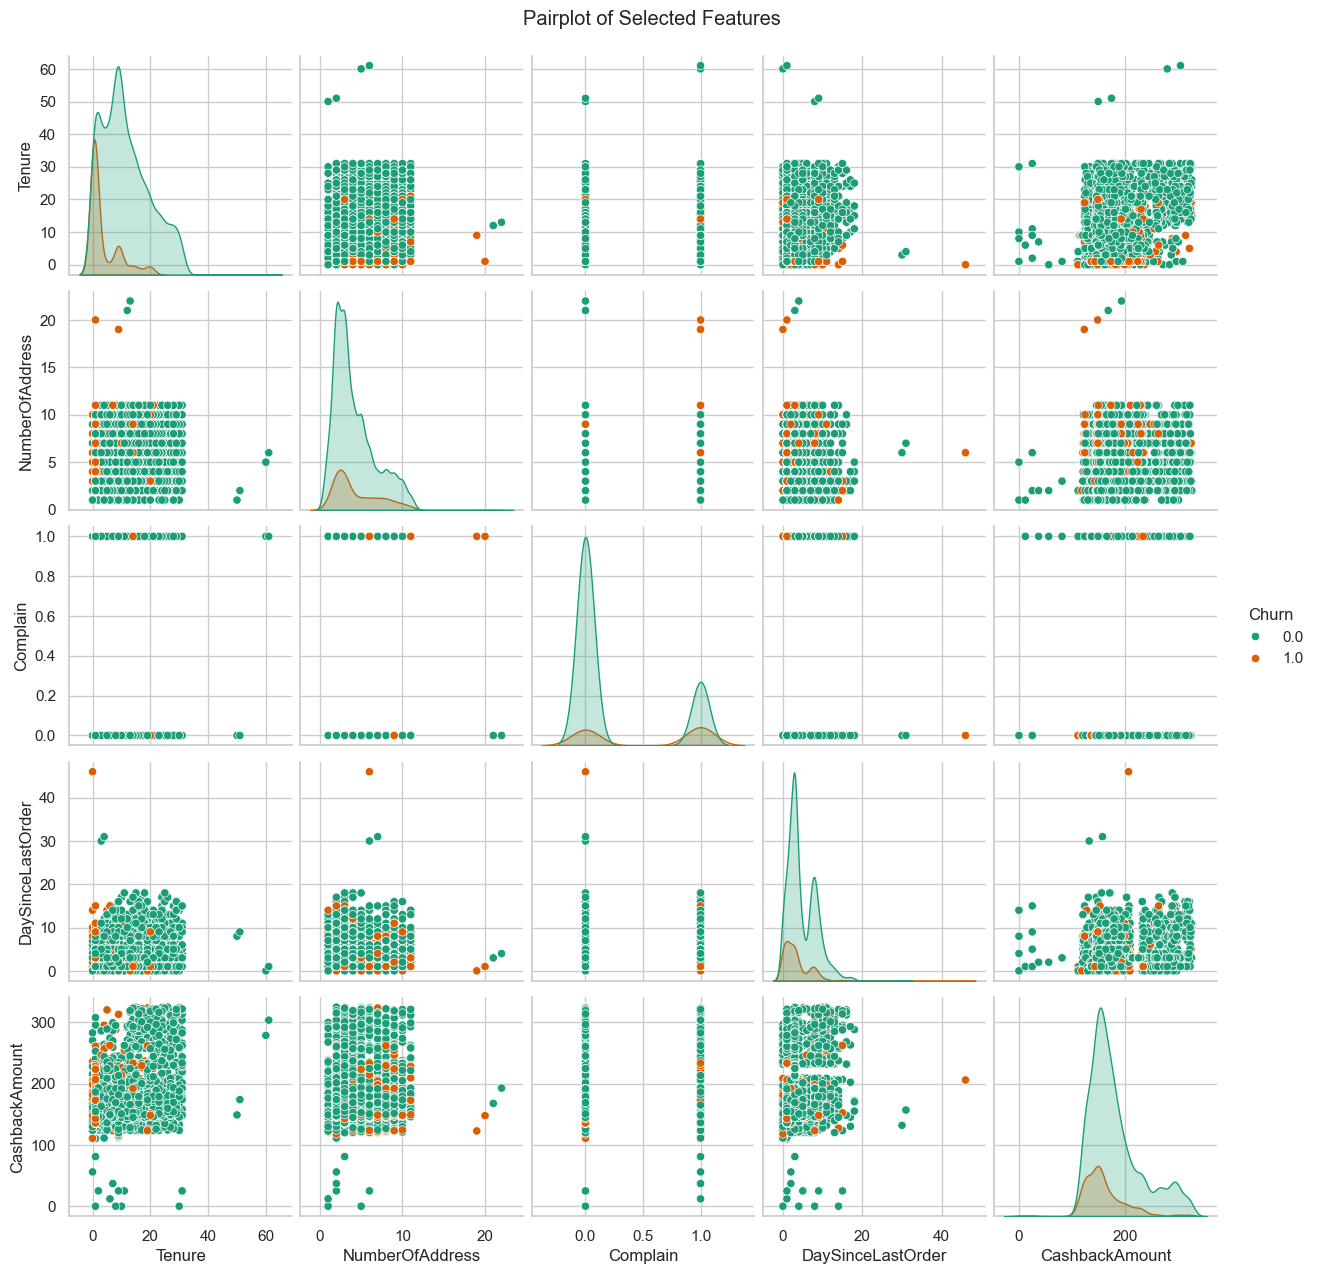

In [29]:
sns.pairplot(eda_df, hue='Churn', palette='Dark2', vars=['Tenure', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount'])
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


## EDA Conclusion

- Những khách hàng lâu năm (thể hiện bởi high Tenure) có tỉ lệ rời bỏ thấp hơn.
- Bên cạnh tỉ lệ giao dịch thường xuyên và cashback amount cũng góp phần giữ khách hàng ở lại và làm giảm tỉ lệ rời bỏ
- Khách hàng thường có xu hướng rời bỏ trong 1 năm đầu tiên. **(Chiếm >65% total churn của dataset)**
- Tỉ lệ **complain** cũng có ảnh hưởng đến tỉ lệ churn-rate. Rút ra được từ biểu đồ phía trên cho thấy tỉ lệ churn-rate của những khách hàng có complain cao hơn 3 lần so với những khách hàng không complain.

- Summary:
    - Cần tập trung chăm sóc những khách hàng mới để giảm tỉ lệ rời bỏ trong 1 năm đầu
    - Đa đạng hóa các chương trình cashback amount, và các chương trình những chương trình ưu đãi khác như các chương trình kỷ niệm 1 năm tính từ ngày có giao dịch đầu tiên
    - Thường xuyên tương tác và nhắc khách quay lại mua hàng định kỳ. Qua đó giảm tỉ lệ rời bỏ.
    - Cải thiện chất lượng dịch vụ và chăm sóc khách hàng để tỉ lệ complain.

---

# **Step 4: Apply Machine Learning Model**

## Model Setup

In [63]:
# Đối với bài toán dạng classification, đây là những model phổ biến nhất cho bài toán phân loại:

models_and_grid = {
    'LogisticRegression':{
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
    },
    
    'DecisionTree':{
        'model': DecisionTreeClassifier(random_state=42),
        'params':{
            'max_depth': [2, 4, 8, 16],
            'min_samples_split': [2, 4, 8, 16],
            'min_samples_leaf': [1,2,4,8]
        }
    },
    
    'RandomForest':{
        'model': RandomForestClassifier(random_state=42),
        'params':{
            'n_estimators': [10, 50, 100],
            'max_depth': [2, 4, 8, 16],
            'min_samples_split': [2, 4, 8, 16],
            'min_samples_leaf': [1,2,4,8]
        }
    }
}

In [ ]:
results = {}


for model_name, config in models_and_grid.items():
    model = config['model']
    params = config['params']
    
    for data_name, data in {'Feature Selected Data': (X_train_selected, X_test_selected, y_train, y_test),
                            'Full Data': (X_train_scaled, X_test_scaled, y_train, y_test)}.items():
        X_train, X_test, y_train, y_test = data
    
        baseline_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean().round(4)
        
        grid = GridSearchCV(
            estimator=model,
            param_grid=params,
            cv=5,
            scoring='accuracy',
            n_jobs=-3
        )
        
        grid.fit(X_train, y_train)
        
        test_score = round(grid.score(X_test, y_test),4)
        
        if model_name not in results:
            results[model_name] = {}

        results[model_name][data_name] = {
            'baseline_cv_mean': baseline_scores.mean(),
            'baseline_cv_std':  baseline_scores.std(),
            'best_cv_mean':     grid.best_score_,
            'best_params':      grid.best_params_,
            'test_score':       test_score
        }
        
for name, res in results.items():
    print(f"=== {name} ===")
    for data_name, data_res in res.items():
        print(f"Results for {data_name}:")
        print(f"Baseline CV accuracy: {data_res['baseline_cv_mean']:.3f} ± {data_res['baseline_cv_std']:.3f}")
        print(f"Tuned   CV accuracy: {data_res['best_cv_mean']:.3f}")
        print(f"Test set accuracy:   {data_res['test_score']:.3f}")
        print(f"Best params:          {data_res['best_params']}\n")


=== LogisticRegression ===
Results for Feature Selected Data:
Baseline CV accuracy: 0.862 ± 0.000
Tuned   CV accuracy: 0.862
Test set accuracy:   0.872
Best params:          {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Results for Full Data:
Baseline CV accuracy: 0.883 ± 0.000
Tuned   CV accuracy: 0.885
Test set accuracy:   0.902
Best params:          {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

=== DecisionTree ===
Results for Feature Selected Data:
Baseline CV accuracy: 0.916 ± 0.000
Tuned   CV accuracy: 0.915
Test set accuracy:   0.944
Best params:          {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}

Results for Full Data:
Baseline CV accuracy: 0.915 ± 0.000
Tuned   CV accuracy: 0.913
Test set accuracy:   0.939
Best params:          {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}

=== RandomForest ===
Results for Feature Selected Data:
Baseline CV accuracy: 0.937 ± 0.000
Tuned   CV accuracy: 0.936
Test set accuracy:   0.960
Best pa


### Conclusion: 

>**Observation:**
>Logistic Regression:

- Feature Selected Data: Mô hình đạt 0.862 accuracy trên dữ liệu cross-validation và 0.872 trên test set.

- Full Data: Accuracy cao hơn ở cả 0.885 (CV) và 0.902 (test set), với tham số tối ưu C=0.1 và penalty='l2'.

>Decision Tree:

- Feature Selected Data: Accuracy đạt 0.915 (CV) và 0.944 (test set) với tham số tối ưu max_depth=16.

- Full Data: Accuracy tương đương với 0.913 (CV) và 0.939 (test set), không có sự khác biệt lớn.

>Random Forest:

- Feature Selected Data: Đạt 0.936 (CV) và 0.960 (test set), với tham số max_depth=16, n_estimators=100.

- Full Data: Accuracy giảm một chút so với dữ liệu đã chọn đặc trưng, với 0.931 (CV) và 0.947 (test set).

> **Conclusion:**
>* Logistic Regression hoạt động tốt nhất trên dữ liệu đầy đủ, nhưng sự khác biệt giữa dữ liệu đã chọn đặc trưng và dữ liệu đầy đủ là không đáng kể.
>* Decision Tree có hiệu suất ổn định trên cả hai loại dữ liệu, với một chút cải thiện khi sử dụng feature selected data.
>* Random Forest cho thấy hiệu suất cao trên cả hai loại dữ liệu, tuy nhiên, feature selected data mang lại kết quả tốt hơn một chút so với dữ liệu đầy đủ.
---

## Visualize the result for each classification models

### Full Features Dataset

In [54]:
model_and_best_params = {
    'Logistic Regression':{
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': 10,
            'penalty': 'l2',
            'solver': 'liblinear'
        }
    },
    
    'Decision Tree':{
        'model': DecisionTreeClassifier(random_state=42),
        'params':{
            'max_depth': 16,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        }
    },
    
    'Random Forest':{
        'model': RandomForestClassifier(random_state=42),
        'params':{
            'n_estimators': 100,
            'max_depth': 16,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        }
    }
}

C:\Users\Alvin Nguyen\AppData\Local\Temp\ipykernel_102384\3258561354.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax = plt.boxplot(x=results, labels=model_and_best_params.keys())


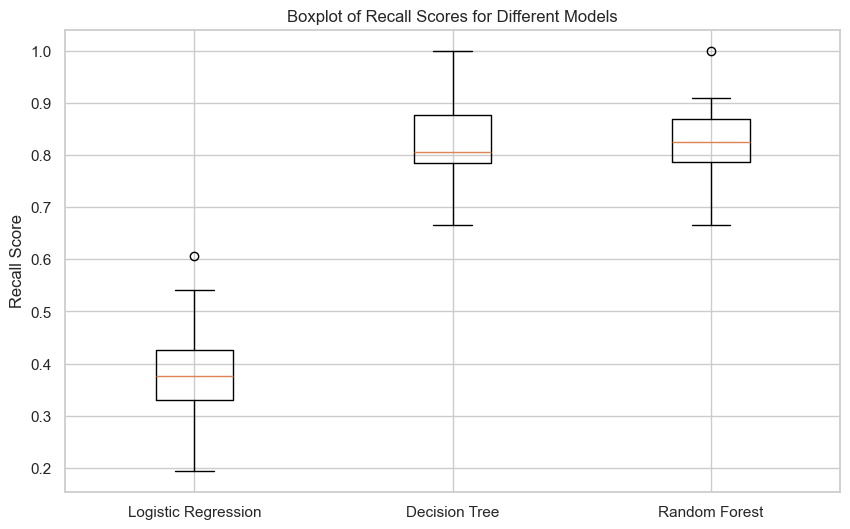

In [55]:
results = []
mean_recall_scores = []

for model_name, config in model_and_best_params.items():
    model = config['model']
    params = config['params']
    
    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    cross_val_scores = cross_val_score(model, X_train_selected, y_train, cv=kf, scoring='recall')
    results.append(cross_val_scores)
    mean_recall_scores.append(cross_val_scores.mean())

fig, ax =plt.subplots(figsize=(10,6))
ax = plt.boxplot(x=results, labels=model_and_best_params.keys())

plt.title('Boxplot of Recall Scores for Different Models')
plt.ylabel('Recall Score')

plt.show()

In [57]:
for model_name, score in zip(model_and_best_params.keys(), mean_recall_scores):
    print(f"Recall mean of {model_name} is {score*100:.3f}%")

Recall mean of Logistic Regression is 38.821%
Recall mean of Decision Tree is 81.974%
Recall mean of Random Forest is 82.170%


---


# **Summary**

- The boxplot illustrates the recall scores for three different machine learning models: **Logistic Regression**, **Decision Tree**, and **Random Forest**. Recall is an important metric, especially in scenarios where it is crucial to identify as many positive instances as possible, even at the cost of some false positives.

**Observation:**
- Logistic Regression has the lowest recall mean at 38.82%, indicating it misses many positive cases.

- Decision Tree shows a significantly higher recall mean at 81.97%, suggesting it is better at identifying positive instances compared to Logistic Regression.

- Random Forest performs similarly to Decision Tree, with a recall mean of 82.17%, slightly outperforming the Decision Tree.

**Recommendation:**
- Focus on improving Logistic Regression: Since Logistic Regression has a relatively low recall, it might not be suitable for scenarios where identifying all positive instances is critical (e.g., customer churn prediction, fraud detection). 

- Use Decision Tree or Random Forest for better recall: Both Decision Tree and Random Forest would be more effective choices. Random Forest generally performs better in terms of generalization due to its ensemble nature, which might be the better option for achieving a high recall while avoiding overfitting.

- Real-world application: In practical scenarios customer churn prediction, the higher recall of Decision Tree and Random Forest will help in catching more positive cases, thus improving the model's ability to minimize false negatives.